# Notebook to test and learn about the Ensemble GP (Experimental)

In [1]:
import numpy as np
from fvgp.ensemble_gp import EnsembleGP
from fvgp.ensemble_gp import hyperparameters
import matplotlib.pyplot as plt


# An ensemble GP means that we allow the prior to be a sum of Gaussian priors. That means we have to define a set of prior-mean and kernel functions
In our case we assume 2 GPs, and therefore 2 prior mean and kernel functions
Feel free to play with those mean functions. Prior mean functions can be any real function, but remember, kernel funcitons have to be positive semi-definite

In [2]:
def func(x):
    i = np.where(x[:,0] < 0.0)
    r = np.zeros((len(x[:,0])))
    r[i] = 0.20
    return r

def mean1(obj,x,hyperparameters):
    return np.ones(len(x)) * hyperparameters[-1]**2
def mean2(obj,x,hyperparameters):
    return np.ones(len(x)) * hyperparameters[-1]**2
def kernel1(x1,x2,hps,obj):
    d = abs(np.subtract.outer(x1[:,0],x2[:,0]))
    return hps[0] * obj.exponential_kernel(d,hps[1])
def kernel2(x1,x2,hps,obj):
    d = abs(np.subtract.outer(x1[:,0],x2[:,0]))
    return hps[0] * obj.exponential_kernel(d,hps[1])

### For ensemble GPs, the hyperparameters are more complicated than for single GPs and therefore we can define an extra object defining the hyperparameters. Thatobject then keeps track of the structure of the hyperparameter vectorized and unvectorized

In [3]:
weights = np.ones(2) / 2.0
weights_bounds = np.array([[0.0001,1.],[0.0001,1.0]])
hps = [np.ones(3)*5.0,np.ones([3])]
hps_bounds = [np.array([[0.01,100],[0.01,100],[0.0,0.001]]),np.array([[0.01,100],[0.01,100],[1.0,1.001]])]
hps_obj = hyperparameters(weights,weights_bounds,hps,hps_bounds)

a = hps_obj.vectorize_hps(weights,hps)
print(a)
a = hps_obj.vectorize_hps(weights,hps)
print("---------")
print(hps_obj.devectorize_hps(a))
print("bounds unvectorized:")
print(weights_bounds)
print(hps_bounds)
print("bounds vectorized")
b = hps_obj.vectorize_bounds(weights_bounds,hps_bounds)
print(b)
print("bounds unvectorized again")
w,h = hps_obj.devectorize_bounds(b)
print(w)
print(h)

[0.5 0.5 5.  5.  5.  1.  1.  1. ]
---------
(array([0.5, 0.5]), [array([5., 5., 5.]), array([1., 1., 1.])])
bounds unvectorized:
[[1.e-04 1.e+00]
 [1.e-04 1.e+00]]
[array([[1.e-02, 1.e+02],
       [1.e-02, 1.e+02],
       [0.e+00, 1.e-03]]), array([[1.000e-02, 1.000e+02],
       [1.000e-02, 1.000e+02],
       [1.000e+00, 1.001e+00]])]
bounds vectorized
[[1.000e-04 1.000e+00]
 [1.000e-04 1.000e+00]
 [1.000e-02 1.000e+02]
 [1.000e-02 1.000e+02]
 [0.000e+00 1.000e-03]
 [1.000e-02 1.000e+02]
 [1.000e-02 1.000e+02]
 [1.000e+00 1.001e+00]]
bounds unvectorized again
[[1.e-04 1.e+00]
 [1.e-04 1.e+00]]
[array([[1.e-02, 1.e+02],
       [1.e-02, 1.e+02],
       [0.e+00, 1.e-03]]), array([[1.000e-02, 1.000e+02],
       [1.000e-02, 1.000e+02],
       [1.000e+00, 1.001e+00]])]


## ...creating some data...

Base GP successfully initiated
(20, 1)


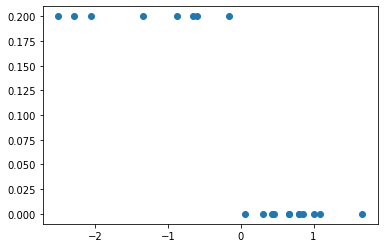

In [4]:
N = 20
points = np.empty((N,1))
points = np.random.uniform(low = -3, high = 3, size = points.shape)
values = func(points)
print("Base GP successfully initiated")
print(points.shape)
values = func(points)


plt.scatter(points,values)

## ...initializing the ensemble GP and trianing it ... oh and checking some derivatives

In [5]:

print(hps_obj.vectorized_hps)

my_gp = EnsembleGP(1,points,values,2,hps_obj,
                gp_kernel_functions = [kernel1,kernel2],
                gp_mean_functions = [mean1,mean2],
                compute_device = "cpu")

grad = my_gp.ensemble_log_likelihood_grad(hps_obj.vectorized_hps)
e = 1e-5
for i in range(len(hps_obj.vectorized_hps)):
    v1 = np.array(hps_obj.vectorized_hps)
    v2 = np.array(hps_obj.vectorized_hps)
    v1[i] = v1[i] - e
    v2[i] = v2[i] + e
    print((my_gp.ensemble_log_likelihood(v2) - my_gp.ensemble_log_likelihood(v1))/(2.*e))

print("-----")   
print(grad)
my_gp.train(hps_obj,
                pop_size = 20,
                tolerance = 0.0001,
                max_iter = 20)




[0.5 0.5 5.  5.  5.  1.  1.  1. ]
CAUTION: you have not provided data variances in fvGP,
they will be set to 1 percent of the data values!
CAUTION: you have not provided data variances in fvGP,
they will be set to 1 percent of the data values!
1.9999999999242843
0.0
-15.596128727679568
-6.975448543045103
70.6168815042929
0.0
0.0
0.0
-----
[ 2.00000000e+00  4.33426730e-39 -1.55961285e+01 -6.97544872e+00
  7.06168815e+01  0.00000000e+00 -0.00000000e+00  0.00000000e+00]
Ensemble fvGP submitted to global optimization
bounds are [[1.000e-04 1.000e+00]
 [1.000e-04 1.000e+00]
 [1.000e-02 1.000e+02]
 [1.000e-02 1.000e+02]
 [0.000e+00 1.000e-03]
 [1.000e-02 1.000e+02]
 [1.000e-02 1.000e+02]
 [1.000e+00 1.001e+00]]
maximum number of iterations:  20
termination tolerance:  0.0001
differential_evolution step 1: f(x)= -30.979
differential_evolution step 2: f(x)= -30.979
differential_evolution step 3: f(x)= -30.979
differential_evolution step 4: f(x)= -30.979
differential_evolution step 5: f(x)= -30

### I hope you saw how the Gaussian priors are places at 0 and 1, just like we would expect from the data.

## Depending on the randomly chosen data you might see that the result is not Gaussian
if you can't see it, run the notebook again

1000
(1000,)


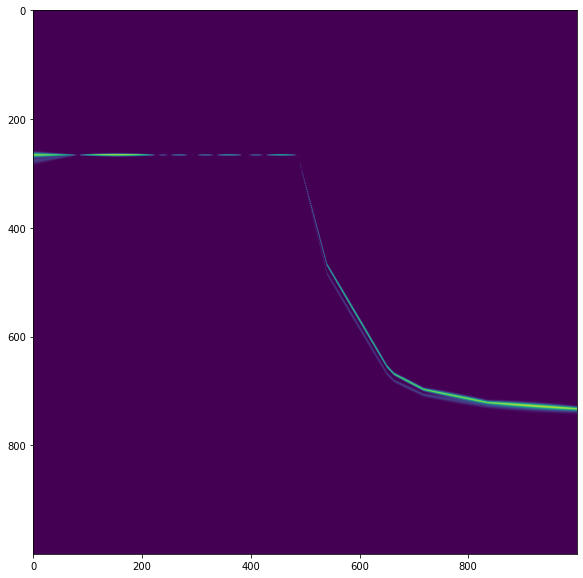

In [6]:
import matplotlib.pyplot as plt
plot_n  = 1000
x_input = np.empty((plot_n,1))
x_input[:,0] = np.linspace(-2,2,plot_n)
y = func(x_input)
post = my_gp.posterior(x_input, res = 1000)["pdf"]
print(len(post))
print(post[0].shape)
fig = plt.figure(figsize = (10,10))
plt.imshow((np.flip(np.array(post).T,axis = 1)))
